In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))

In [2]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
import os
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import wandb
from tqdm import tqdm
from datetime import datetime
import pickle

import cv2
from skimage.io import imsave
from skimage.transform import resize
from skimage.measure import block_reduce
import skimage.segmentation as seg
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, f1_score, accuracy_score, balanced_accuracy_score, average_precision_score

from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize
from torchvision.transforms import InterpolationMode
# from kornia.geometry.transform import Resize
from kornia.augmentation import Normalize

from config import TrainConfig, GPU_ID
from dataio.dataloader import probe_data_folder, BraTS18Binary
from models.resnet import get_resnet50_attn_classifier
from models.unet import get_unet_encoder_classifier

figsize = (24, 24)

os.environ["CUDA_VISIBLE_DEVICES"] = GPU_ID

In [3]:
# Model directory and configuration

base_dir = "/hdd0/projects/regex/logs/unet_encoder_4attn_marginals/20210513_15:39:29"
model_file = "unet_encoder_4attn_marginals__best__epoch=009_score=0.9632.pt"

config_file = "params.p"

config_handler = open(os.path.join(base_dir, config_file), 'rb')
params = pickle.load(config_handler)
params["weights"] = model_path = os.path.join(base_dir, model_file)

transforms = Compose([
                Normalize(mean=torch.tensor([149.56119, 165.83559, 166.13501, 112.61901]),
                          std=torch.tensor([636.8766, 653.8386, 759.8256, 718.83594])),
                Resize((256, 256), interpolation=InterpolationMode.NEAREST)])

mask_transforms = Resize((256, 256), interpolation=InterpolationMode.NEAREST)

In [4]:
# Load dataset
train_metadata, val_metadata, _ = probe_data_folder(params["data_path"],
                                                 train_frac=params["train_frac"],
                                                 bad_files=params["bad_files"],
                                                 subsample_frac=params["subsample_frac"])
val_metadata = [(image, mask) for (image, mask) in val_metadata if "y=1" in image]

val_dataset = BraTS18Binary(params["data_path"],
                      val_metadata,
                      transforms=transforms,
                      mask_transforms=mask_transforms,
                      prefetch_data=params["prefetch_data"],
                      get_mask=True,
                      shuffle=True,
                      random_state=41)
val_loader = DataLoader(dataset=val_dataset,
                        num_workers=1,
                        pin_memory=True,
                        batch_size=1,
                        shuffle=False)

  Total of 208 train patients, 52 test patients
  Total of 16878 train slices, 4778 test slices


In [5]:
# Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# params["use_gpu"] = False
# device = "cpu"
model = get_unet_encoder_classifier(**params)

model = model.to(device)

Loading pretrained model from: '/hdd0/projects/regex/logs/unet_encoder_4attn_marginals/20210513_15:39:29/unet_encoder_4attn_marginals__best__epoch=009_score=0.9632.pt'
Total parameters: 4986886
Total trainable parameters: 272390


In [6]:
y_true = []
y_pred = []
y_prob = []
images = []
masks = []
model_attns = []
model.eval()

for j, sample in tqdm(enumerate(val_loader), total=len(val_loader)):
    # Image + Prediction
    mri, (targets, masks_t) = sample
    mri_image = mri.detach().cpu().squeeze(0).squeeze(0).numpy()
    targ = targets.detach().cpu().item()
    mask = masks_t.detach().cpu()
    mask = mask_transforms(mask.unsqueeze(0)).squeeze(0)
    masks.append(mask.numpy())
    y_true.append(targ)
    
    mri = mri.to(device)
    outputs, attn, marginals = model(mri)
    probs = torch.softmax(outputs, dim=1).cpu().detach()[0]
    y_prob.append(probs.numpy())
    y_pred.append(torch.argmax(probs).item())
    img_fname = f"image_{j:04d}_pred={str(probs.numpy().round(2))}_label={targ}.npy"
    images.append((img_fname, mri_image, mask))
    
    # Attns
    attns = []
    for i, attn_step in enumerate(attn):
        shape = list(attn_step.shape[1:])
        attn = attn_step.squeeze(0).detach().cpu().numpy()
        attn_fname = f"image_{j:04d}_attn_level={i+1}_shape={shape}"
        attns.append((attn_fname, attn))
    model_attns.append(attns)

100%|██████████| 2389/2389 [00:29<00:00, 82.15it/s]


In [7]:
print(balanced_accuracy_score(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))
print(confusion_matrix(y_true, y_pred, normalize="true"))

0.95772289660946
[[   0    0]
 [ 101 2288]]
[[0.        0.       ]
 [0.0422771 0.9577229]]


/home/tomron27/miniconda3/envs/petct/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


In [8]:
modality_idx = 2

def plot_attns_raw(idx):
    if not isinstance(idx, int):
        row = idx
    else:
        row = model_attns[idx]
    img_fname, img, mask = images[idx]
    img = img[modality_idx]
    fig, axes = plt.subplots(1,6,figsize=figsize)
    fig.subplots_adjust(hspace=-0.5)
    axes[0].imshow(img, cmap="gray")
    axes[0].set_title(img_fname, fontsize=14)
    axes[0].axis('off')
    axes[1].imshow(img, cmap="gray")
    axes[1].imshow(mask[0], cmap="Greens", alpha=0.4)
    axes[1].axis('off')
    vmin = None #row[-1][1].min()
    vmax = None #row[-1][1].max()
    for j, (ax, attn_plot) in enumerate(zip(axes.flat[2:], row)):
        attn_fname, attn_img = attn_plot
        im = ax.imshow(attn_img, cmap="jet", vmin=vmin, vmax=vmax)
        attn_fname += f"\nmin: {attn_img.min():.5f}, max:{attn_img.max():.5f}"
        ax.set_title(attn_fname, fontsize=8)
    plt.show()
    
def plot_attns(idx):
    if not isinstance(idx, int):
        row = idx
    else:
        row = model_attns[idx]
    img_fname, img, mask = images[idx]
    img = img[modality_idx]
    fig, axes = plt.subplots(1,6,figsize=figsize)
    fig.subplots_adjust(hspace=-0.5)
    axes[0].imshow(img, cmap="gray")
    axes[0].set_title(img_fname, fontsize=14)
    axes[0].axis('off')
    axes[1].imshow(img, cmap="gray")
    axes[1].imshow(mask[0], cmap="Greens", alpha=0.4)
    axes[1].axis('off')
    vmin = None #row[-1][1].min()
    vmax = None #row[-1][1].max()
    for j, (ax, attn_plot) in enumerate(zip(axes.flat[2:], row)):
        attn_fname, attn_img = attn_plot
        attn_image_resize = resize(attn_img, img.shape)
        ax.imshow(img, cmap="gray")
        im = ax.imshow(attn_image_resize, cmap="jet", alpha=0.4, vmin=vmin, vmax=vmax)
        attn_fname += f"\nmin: {attn_img.min():.5f}, max:{attn_img.max():.5f}"
        ax.set_title(attn_fname, fontsize=8)
        ax.axis('off')
    axes[-1].axis('off')
    plt.show()
    plot_attns_raw(idx)

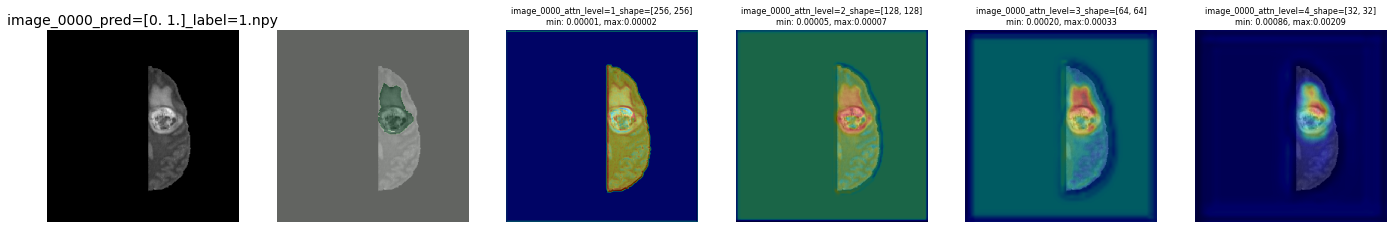

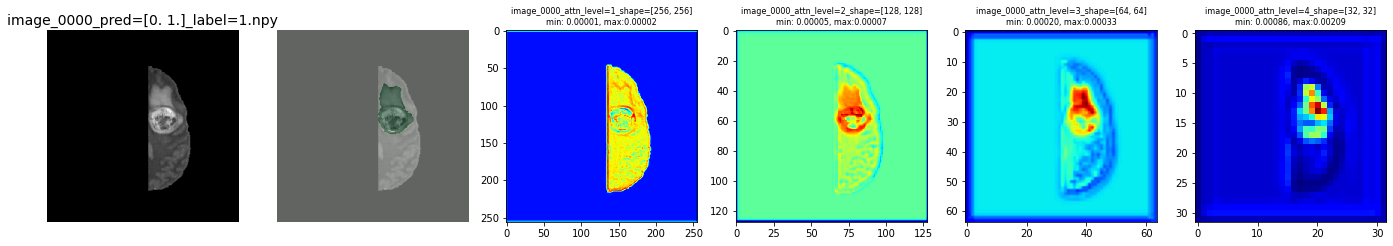

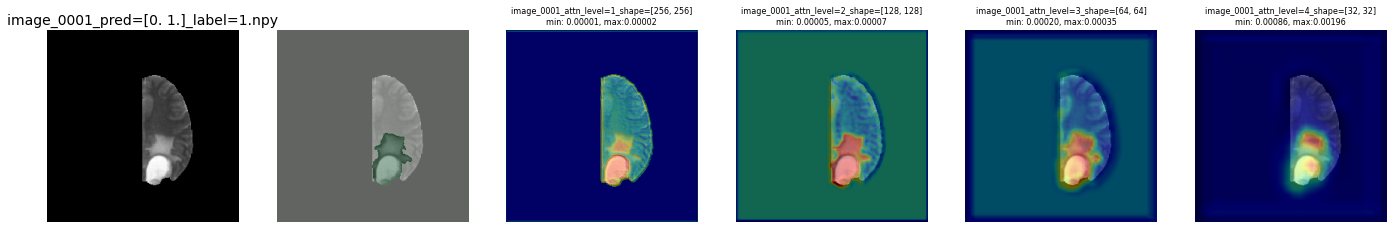

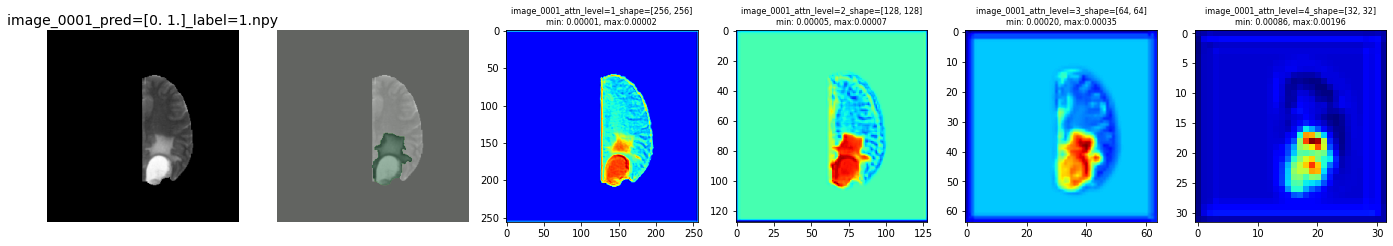

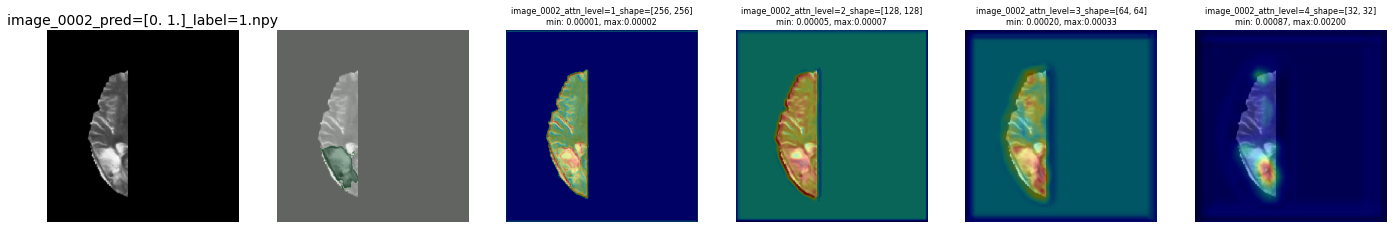

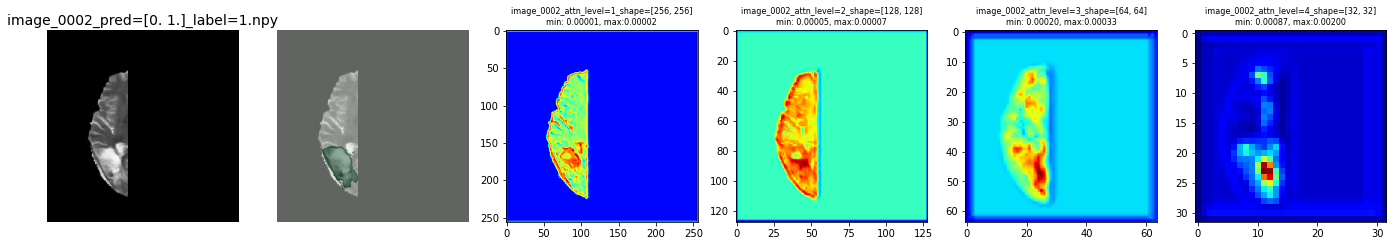

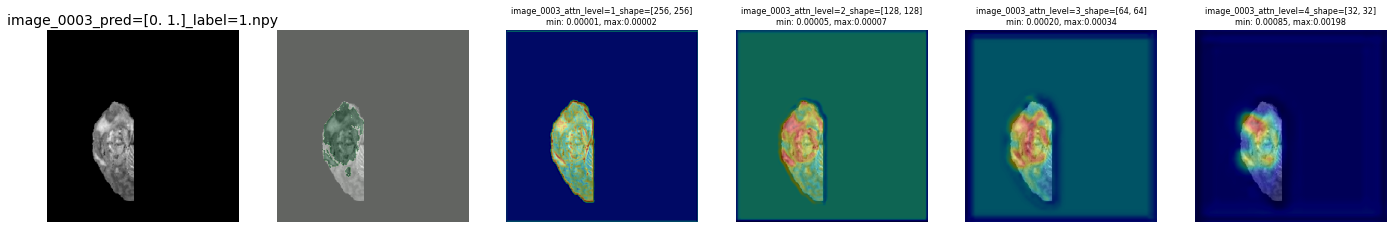

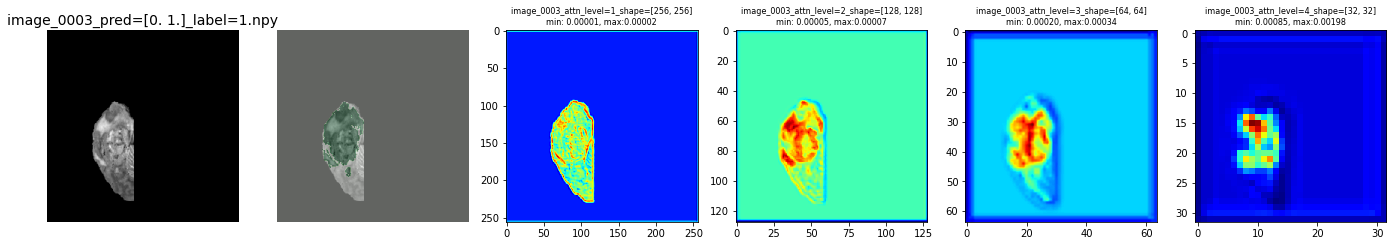

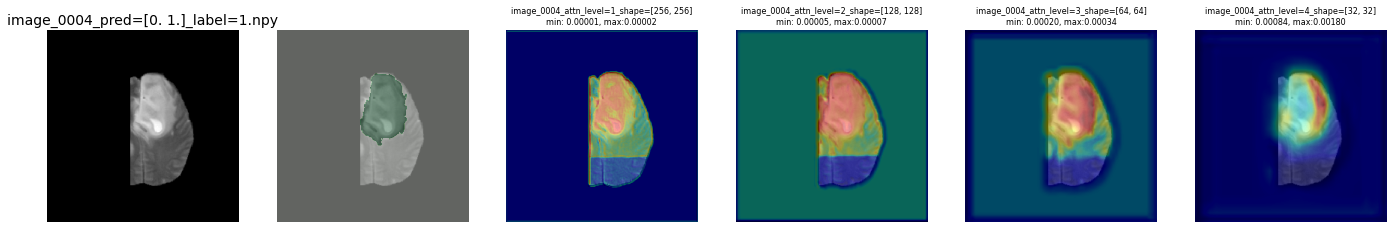

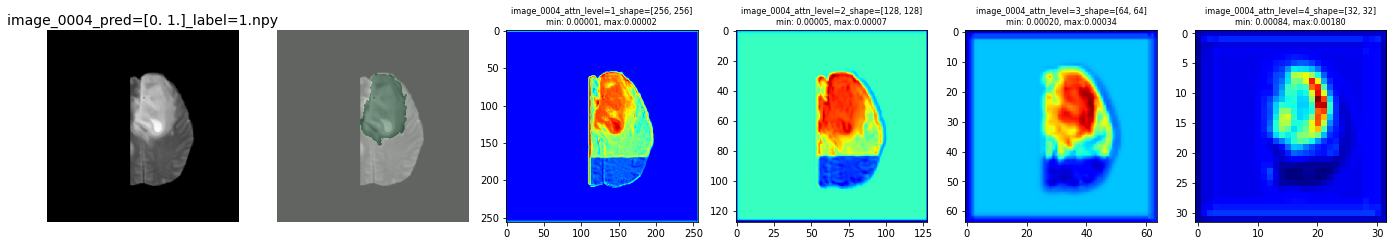

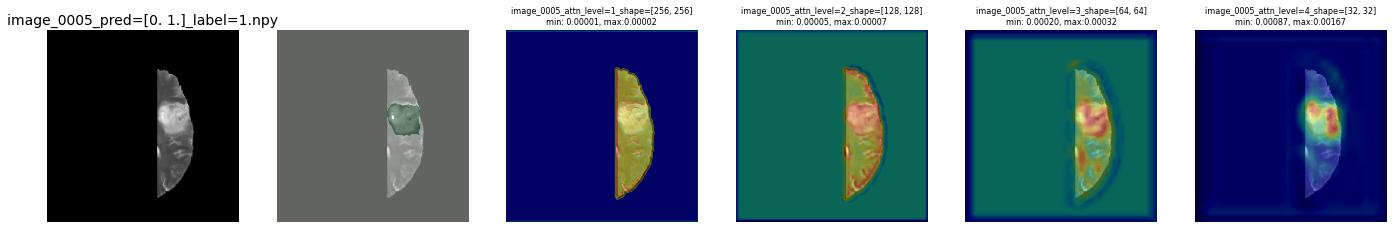

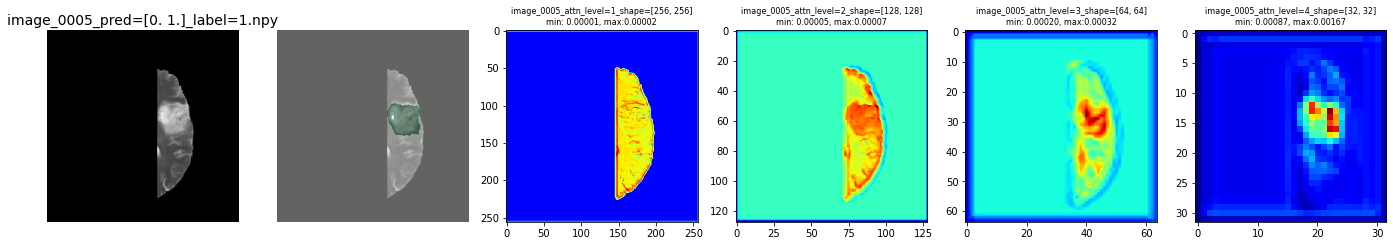

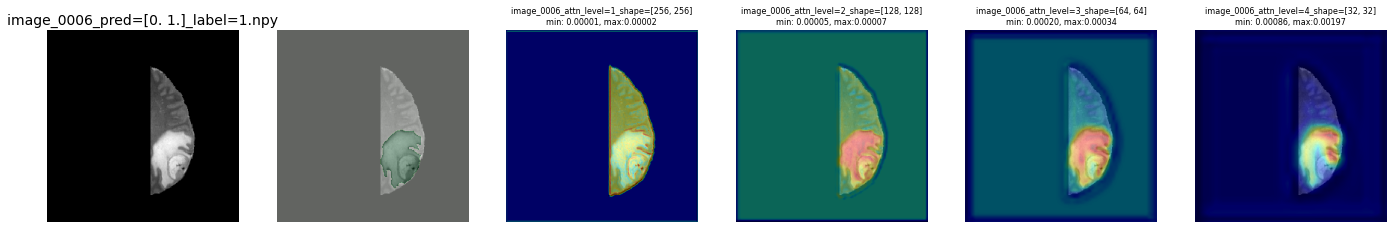

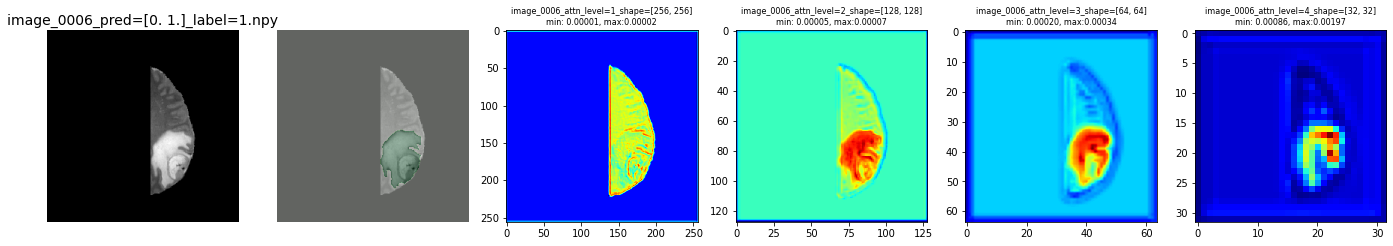

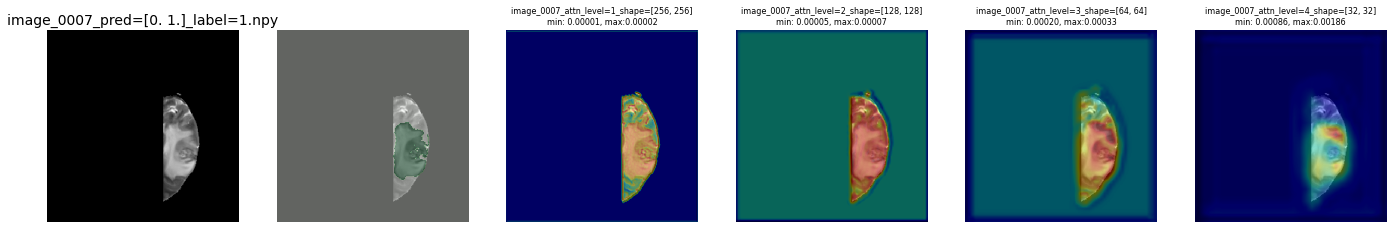

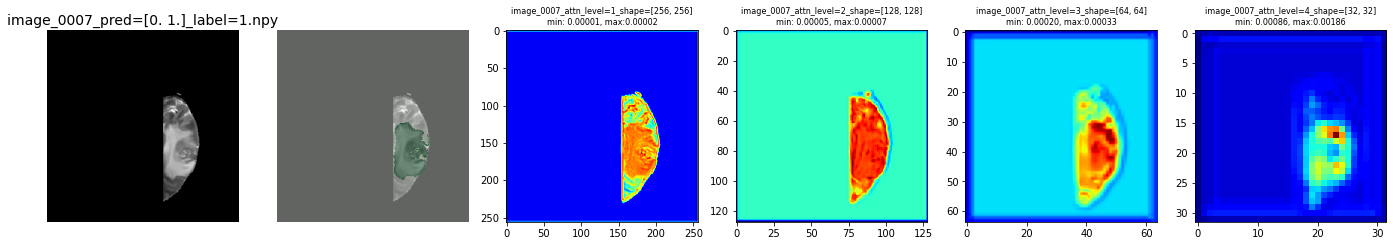

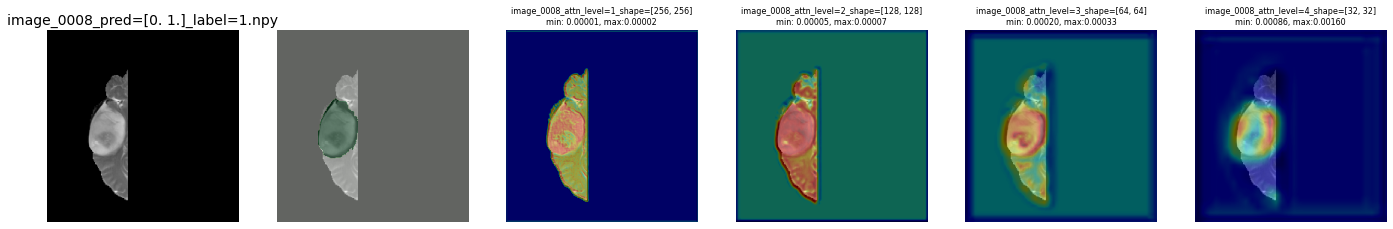

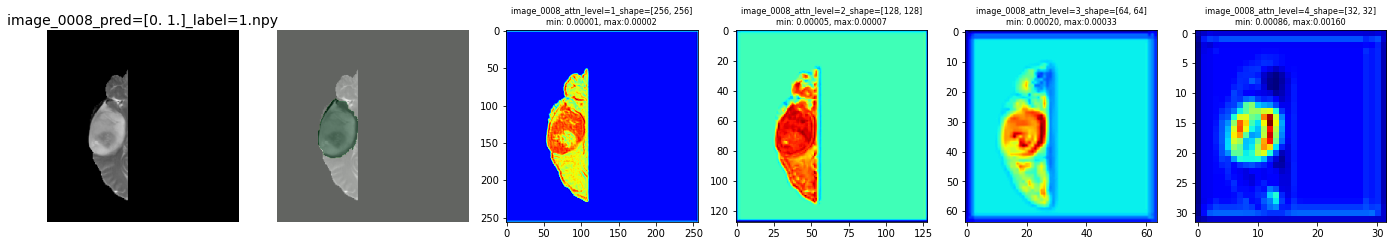

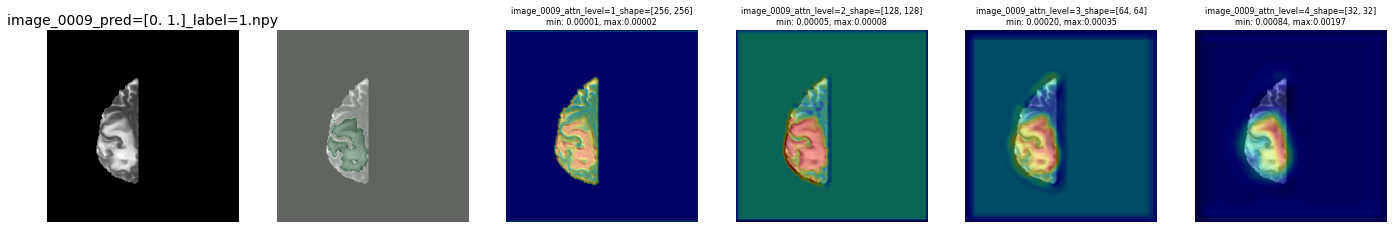

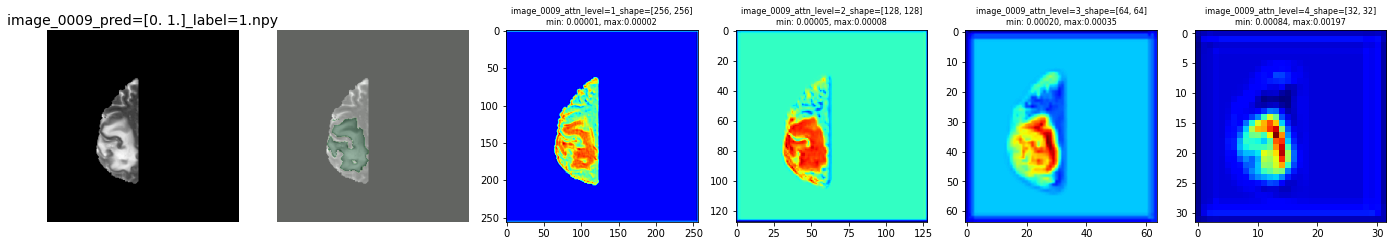

In [9]:
for i in range(10):
    plot_attns(i)

In [10]:
def get_ap(mask, heatmap):
    mask = mask[0]
    if heatmap.shape != mask.shape:
        resize = Resize(mask.shape, interpolation=InterpolationMode.NEAREST)
        heatmap = resize(torch.tensor(heatmap).unsqueeze(0)).squeeze(0) / ((mask.shape[0] / heatmap.shape[0]) **2)
        heatmap = heatmap.numpy()
    return average_precision_score(mask.ravel(), heatmap.ravel())

In [11]:
# IoU playground
idx = 1
attn_level = 3
modality_idx = 2
img_fname, img, mask = images[idx]
img = img[modality_idx]
mask = mask[0]
heatmap = model_attns[idx][attn_level][1]
if heatmap.shape != img.shape:
    print(heatmap.shape, img.shape)
    r = Resize(img.shape, interpolation=InterpolationMode.NEAREST)
    heatmap = r(torch.tensor(heatmap).unsqueeze(0)).squeeze(0) / ((img.shape[0] / img.shape[0]) **2)
    heatmap = heatmap.numpy()

(32, 32) (256, 256)


0.8875875605335993


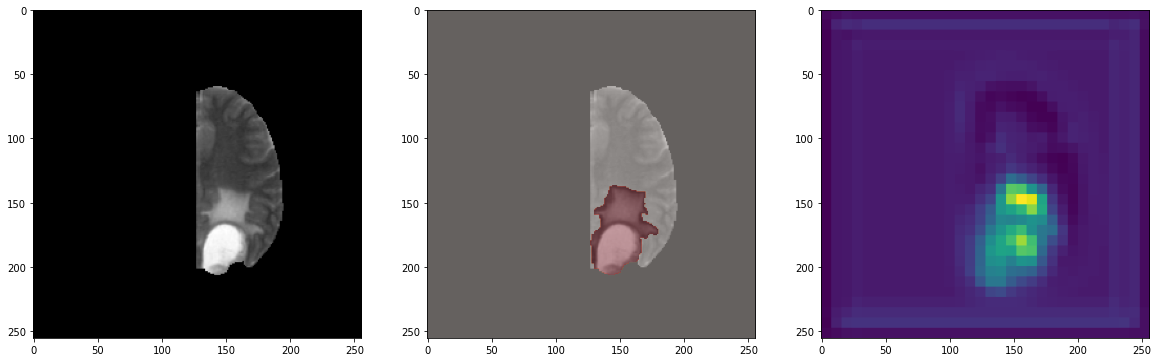

In [12]:
fig, ax = plt.subplots(1,3,figsize=(20, 20))
ax[0].imshow(img, cmap="gray")
ax[1].imshow(img, cmap="gray")
ax[1].imshow(mask, cmap="Reds", alpha=0.4)
ax[2].imshow(heatmap)
print(get_ap(mask[None, ...], heatmap))

In [13]:
ap_list = []
for i, (y, mask) in enumerate(zip(y_true, masks)):
    ap_score = get_ap(mask, model_attns[i][attn_level][1])
    ap_list.append(ap_score)
map_score = sum(ap_list) / len(ap_list)
print(map_score)

0.7307591250291456
